Unique Labels: 62
Total Images: 4575


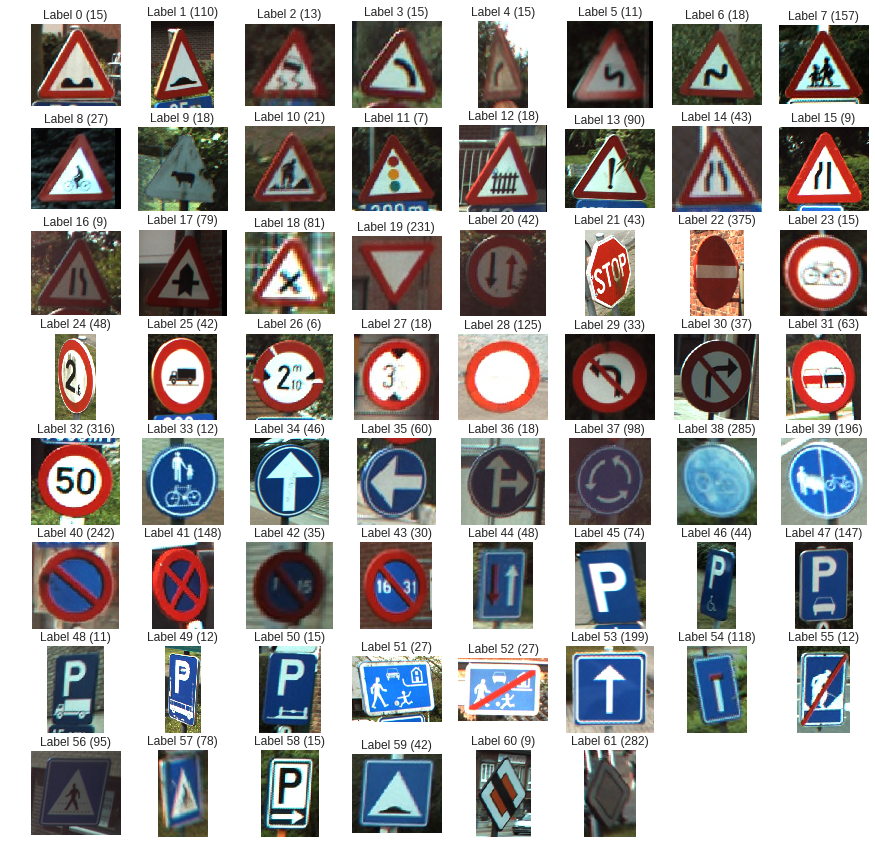

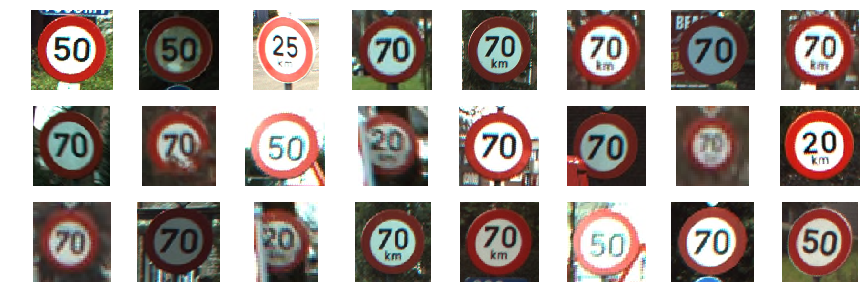

shape: (81, 76, 3), min: 0, max: 255
shape: (136, 142, 3), min: 0, max: 255
shape: (82, 92, 3), min: 0, max: 204
shape: (320, 320, 3), min: 10, max: 255
shape: (56, 56, 3), min: 7, max: 205


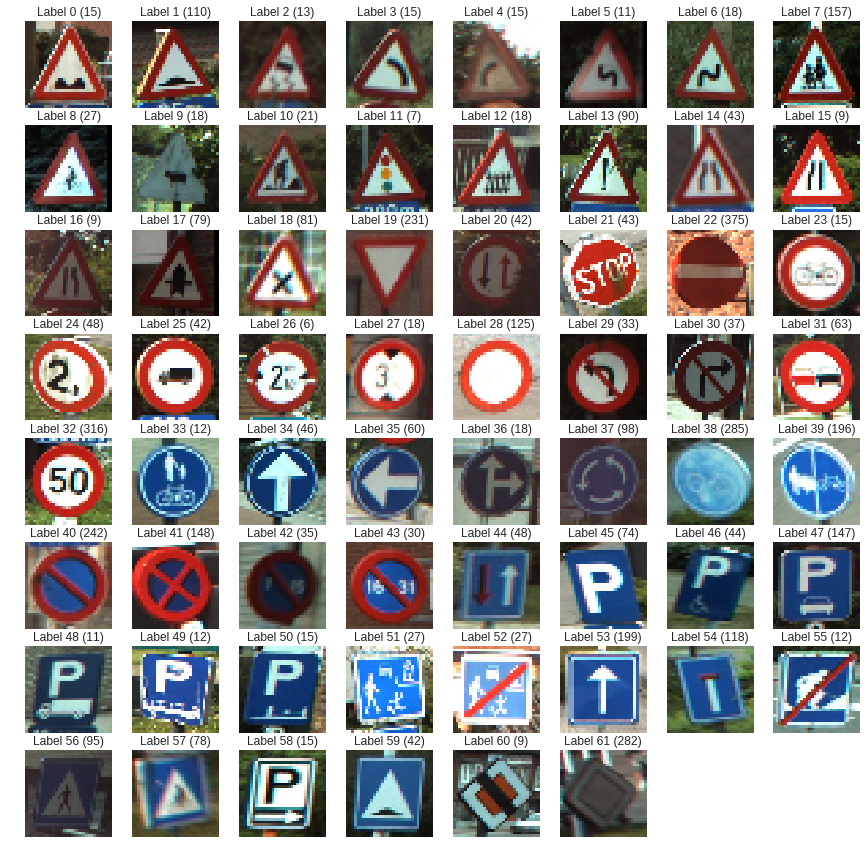

shape: (32, 32, 3), min: 0.0020603553921572735, max: 1.0
shape: (32, 32, 3), min: 0.02193627450980325, max: 1.0
shape: (32, 32, 3), min: 0.0, max: 0.7845588235294118
shape: (32, 32, 3), min: 0.063725490196077, max: 1.0
shape: (32, 32, 3), min: 0.03805147058823449, max: 0.7648284313725484
labels:  (4575,) 
images:  (4575, 32, 32, 3)
images_flat:  Tensor("Flatten/flatten/Reshape:0", shape=(?, 3072), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)
Loss:  4.2530923
Loss:  3.4019964
Loss:  3.0284307
Loss:  2.8514087
Loss:  2.7544312
Loss:  2.6910756
Loss:  2.645657
Loss:  2.6105196
Loss:  2.5817785
Loss:  2.557506
Loss:  2.5364528
Loss:  2.5178056
Loss:  2.5011652
Loss:  2.4861953
Loss:  2.4726386
Loss:  2.4602861
Loss:  2.4489768
Loss:  2.438574
Loss:  2.4289703
Loss:  2.4200804
Loss:  2.411821
[22, 32, 32, 19, 38, 34, 61, 22, 19, 45]
[22  0

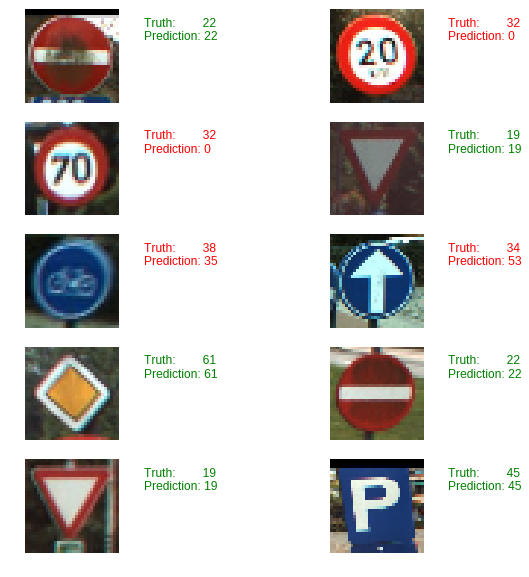

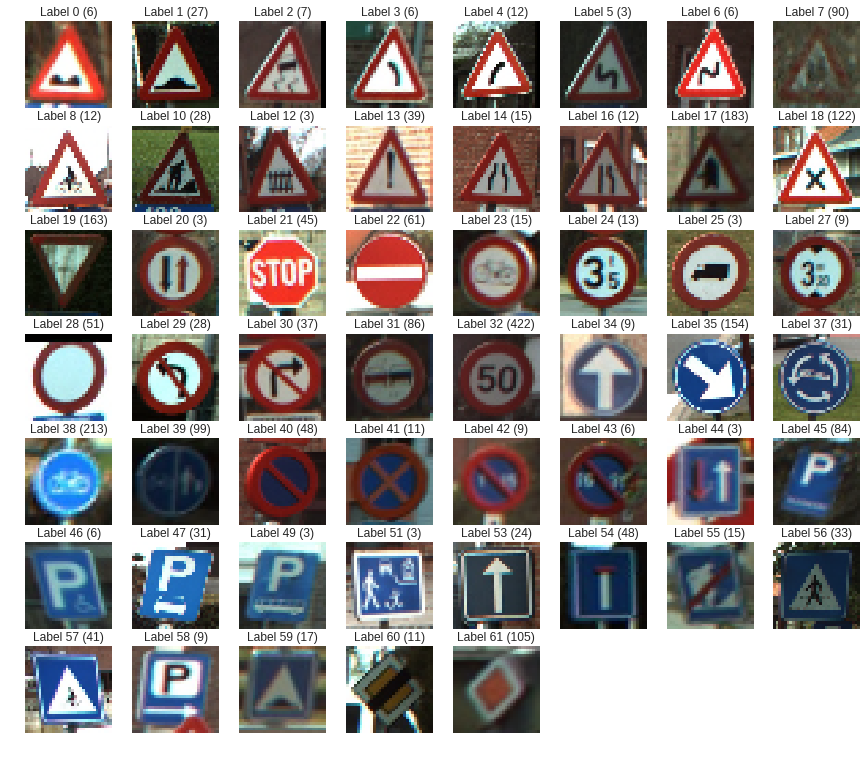

Accuracy: 84.416


In [41]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

%matplotlib inline

def load_data(data_dir):
    
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

# Load training and testing datasets.
train_data_dir = os.path.join("Training")
test_data_dir = os.path.join('Testing')

images, labels = load_data(train_data_dir)
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 32)

for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))
    
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]
display_images_and_labels(images32, labels)

for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))
    
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.contrib.layers.flatten(images_ph)

    # Fully connected layer. 
    # Generates logits of size [None, 62]
    logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))

    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    init = tf.global_variables_initializer()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

session = tf.Session(graph=graph)

_ = session.run([init])

for i in range(201):
    _, loss_value = session.run([train, loss], 
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)
        
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

    
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)

# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]

# Run predictions against the full test set. 
predicted = session.run([predicted_labels], feed_dict={images_ph: test_images32})[0] 

# Calculates Accuracy. 
count = 0
for y in test_labels:
  for z in predicted:
    if(int(y)==int(z)):
      count+=1
accuracy = count / len(test_labels) 
print("Accuracy: {:.3f}".format(accuracy))

session.close()